# Homework 2: Trees and Calibration


## Instructions

Please push the .ipynb, .py, and .pdf to Github Classroom prior to the deadline. Please include your UNI as well.

**Make sure to use the dataset that we provide in CourseWorks/Classroom.**

**There are a lot of applied questions based on the code results. Please make sure to answer them all. These are primarily to test your understanding of the results your code generate (similar to any Data Science/ML case study interviews).**

## Name:  Ta-Wei (David) Huang

## UNI: th3061

## The Dataset

### Description
This dataset contains details of individual relating to their health. The target is stored in **strokes** column which is binary variable indicating either 0 or 1. The goal of the assignment is a binary classification task to predict wether the person will get a stroke depending on other health factors

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [265]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import make_column_transformer
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import	precision_score, recall_score, 	accuracy_score, confusion_matrix, ConfusionMatrixDisplay, f1_score, make_scorer
from sklearn import tree
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier

## Question 1: Decision Trees

**1.1: Load the provided dataset**

In [6]:
## YOUR CODE HERE
df = pd.read_csv('Data/healthcare-dataset-stroke-data.csv')

**1.2: Show or Plot % of missing values in each column. Would you consider dropping any columns or assuming we want to train a decision tree, would you consider imputing the missing values? If not, why? (Remove the columns that you consider dropping)**

Percentage of missing values in each column:
id                   0.000000
gender               0.000000
age                  0.000000
hypertension         0.000000
heart_disease        0.000000
ever_married         0.000000
work_type            0.000000
Residence_type       0.000000
avg_glucose_level    0.000000
bmi                  3.933464
smoking_status       0.000000
stroke               0.000000
dtype: float64


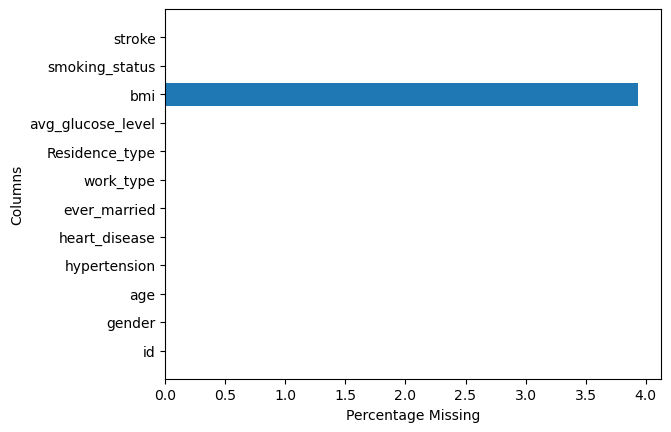

In [9]:
## YOUR CODE HERE
missing_data = df.isnull().sum()
total_data = len(df)
percentage_missing = (missing_data / total_data) * 100

print("Percentage of missing values in each column:")
print(percentage_missing)

# plot the percentage of missing value
plt.barh(percentage_missing.index, percentage_missing)
plt.xlabel('Percentage Missing')
plt.ylabel('Columns')
plt.show()

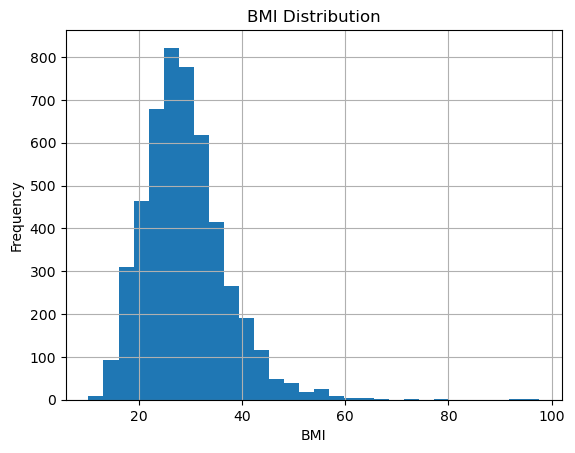

In [10]:
# handle missing values in bmi column
df['bmi'].hist(bins=30)
plt.title('BMI Distribution')
plt.xlabel('BMI')
plt.ylabel('Frequency')
plt.show()

In [11]:
# since the distribution of bmi skew to the right, I'll use the median to impute the data
df['bmi'].fillna(df['bmi'].median(), inplace=True)

**Check for the number of rows after handling null values, each column should have the same number of non-null count**

In [12]:
# check missing value again
missing_data = df.isnull().sum()
total_data = len(df)
percentage_missing = (missing_data / total_data) * 100

print("Percentage of missing values in each column:")
print(percentage_missing)

Percentage of missing values in each column:
id                   0.0
gender               0.0
age                  0.0
hypertension         0.0
heart_disease        0.0
ever_married         0.0
work_type            0.0
Residence_type       0.0
avg_glucose_level    0.0
bmi                  0.0
smoking_status       0.0
stroke               0.0
dtype: float64


**1.3 Print the distribution of the target variable. Is the dataset balanced?**

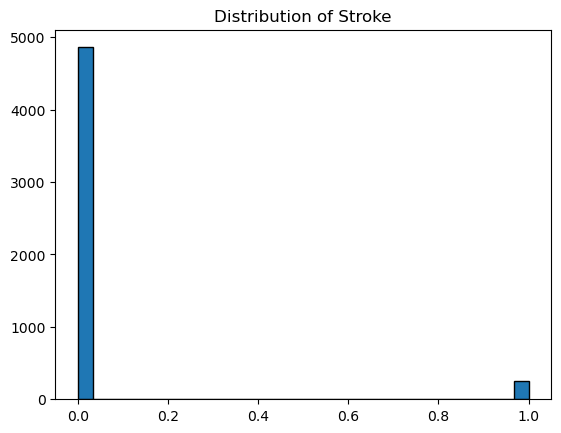

In [14]:
# print the distribution of stroke variable
plt.hist(df['stroke'], bins=30, edgecolor='black')
plt.title('Distribution of Stroke')
plt.show()

**Your Comments Here**:

**1.4: Plot side-by-side bars of class distribtuion for each category for the categorical feature and the target categories.**

**Clarification with Example below : Here `flWinner` is the Target Variable and `descMapName` is a categorical feature. You are required to make such side-by-side bar plot for each categorical feature with repect to it's class distribution with the target feature for our dataset.**

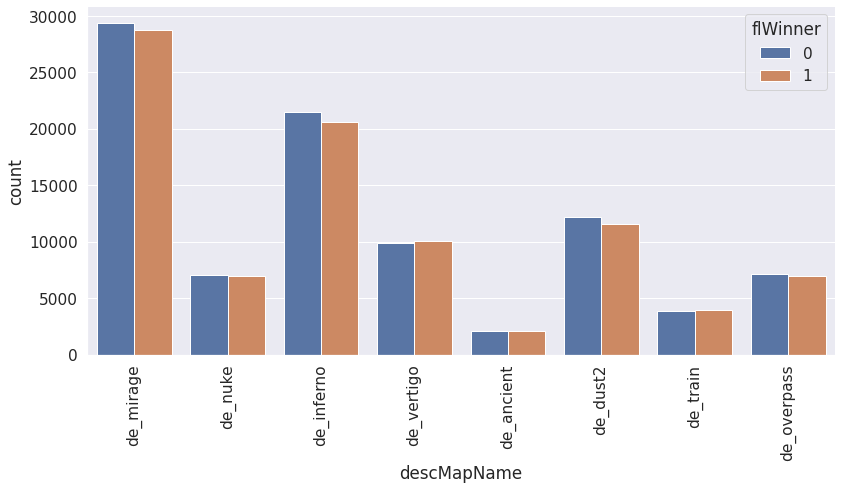

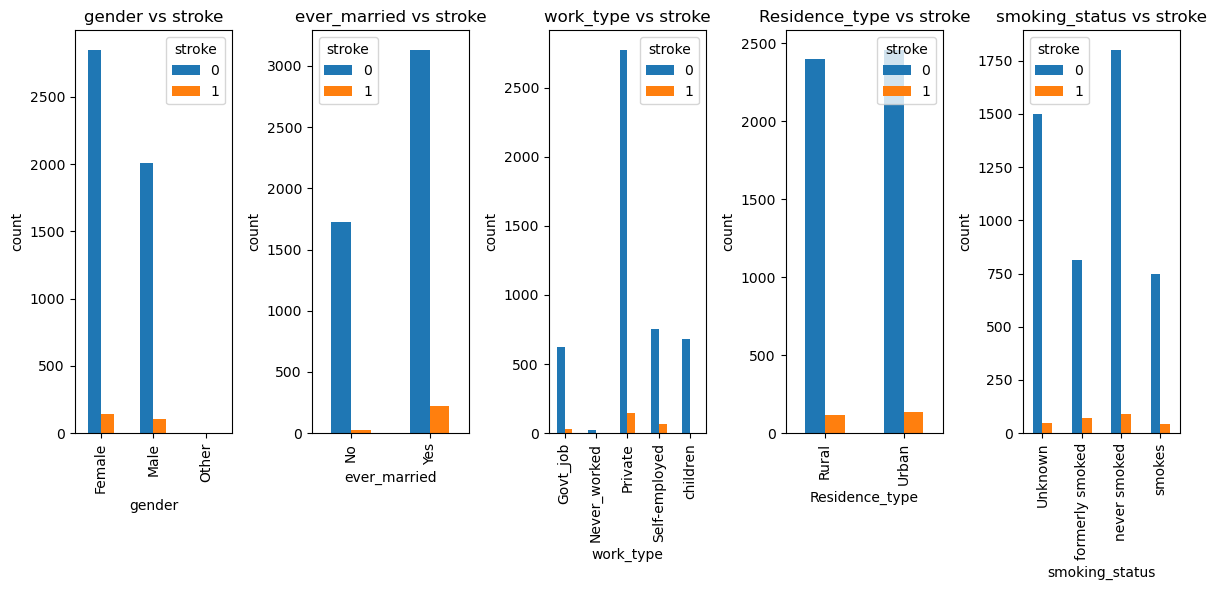

In [45]:
df_cat = df.select_dtypes('object')
# for colname in list(df_cat.columns):
#     pd.crosstab(df['gender'],df['stroke']).plot(kind="bar")
fig, axes = plt.subplots(1, 5, figsize=(12, 6))

# Plot 1: Gender vs Stroke
for i in range(len(df_cat.columns)):
    pd.crosstab(df[df_cat.columns[i]], df['stroke']).plot(kind='bar', ax=axes[i])
    axes[i].set_title(df_cat.columns[i] +' vs stroke')
    axes[i].set_xlabel(df_cat.columns[i])
    axes[i].set_ylabel('count')

plt.tight_layout()
plt.show()

**1.5: Preprocess the data (Handle the Categorical Variable). Do we need to apply scaling? Briefly Justify.**

In [74]:
df_X = df.drop(columns=['stroke','id'])
df_Y = df['stroke'].astype(int)

In [75]:
# Handle the categorical variable
print("The categorical columns we need to handle:\n", list(df_X.select_dtypes('object').columns))

The categorical columns we need to handle:
 ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']


In [244]:
# crosstable of variable gender:
print(pd.crosstab(df['gender'], df['stroke']))
# the number of (gender == other) = 1 -> decide to remove
df.drop(df[df['gender']=='Other'].index, inplace=True)
df_X = df.drop(columns=['stroke','id'])
df_Y = df['stroke'].astype(int)

stroke     0    1
gender           
Female  2853  141
Male    2007  108
Other      1    0


In [249]:
print(pd.crosstab(df['gender'], df['stroke']))

stroke     0    1
gender           
Female  2853  141
Male    2007  108


In [267]:
# divide data based on the type of the features
df_X_cat = df_X.select_dtypes('object')
df_X_num = df_X.select_dtypes(include=[np.number])
ohe_features = list(df_X_cat.columns)
num_features = list(df_X_num.columns)

**Your Comments Here**:

In the tree-based models, we don't need to do the scaling, as the model splits the nodes based on the value itself. As a result, scaling do not provide benefit for the model performance. 


**1.6: Split the data into development and test datasets. Which splitting methodology did you choose and why?**

In [268]:
## YOUR CODE HERE
X_dev, X_test, y_dev, y_test = train_test_split(df_X, df_Y, stratify= df_Y, test_size=0.2, random_state=1)

**Your Comments Here**:

I use train_test_split's "stratify" parameter to make a split so that the proportion of values in the development and test datasets will be the same as the proportion of target variable

**1.7: Fit a Decision Tree on the training data until all leaves are pure. What is the performance of the tree on the development set and test set? Provide metrics you believe are relevant and briefly justify.**


**HINT : Think about the proportion of the class label**

In [271]:
## Fit Decision Tree
# max_depth = None, the nodes are expaned until all leaves are pure
clf = DecisionTreeClassifier(random_state=0)

# Do one-hot-encoding on categorical features
preprocess = make_column_transformer(
                                    (OneHotEncoder(handle_unknown='ignore'),ohe_features),
                                     remainder="passthrough")
scorer = make_scorer(recall_score, average='macro')
pipe = make_pipeline(preprocess,
                    GridSearchCV(clf,
                                param_grid = {},
                                return_train_score=True,
                                scoring=scorer)) #scoring='recall'
pipe.fit(X_dev, y_dev)
grid_search_results = pipe.named_steps['gridsearchcv']
print(f"Best train score: ", grid_search_results.best_score_)
print(f"Best train alpha: ", grid_search_results.best_params_)
print(f"Test score:", pipe.score(X_test, y_test))

Best train score:  0.5572843973807984
Best train alpha:  {}
Test score: 0.577366255144033


**Your Comments Here**

I use recall to evaluate the performance of the model, as I want to lower the False Negative to get better prediction on whether a person will get the stroke. Accuracy would be not appropriate since the model might predict majority class most of the time and still achieve high score. 

**1.8: Visualize the trained tree until the max_depth 8**

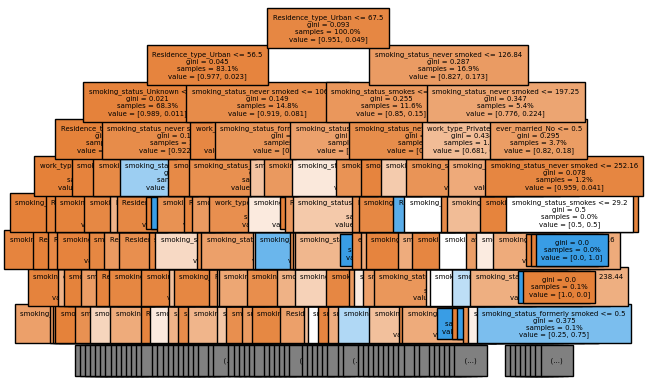

In [272]:
best_tree = grid_search_results.best_estimator_
ohe_feature_names = preprocess.named_transformers_["onehotencoder"].get_feature_names_out().tolist()
feature_names = num_features + ohe_feature_names
tree_dot = plot_tree(best_tree, feature_names=feature_names, fontsize=5, filled=True, max_depth=8, proportion=True)
plt.show()

**1.9: Prune the tree using one of the techniques discussed in class and evaluate the performance. Carefully consider which metric to use considering the imbalance in the class label.**

Best train score:  0.5572843973807984
Best train alpha:  {'max_depth': 20}
Test score: 0.577366255144033


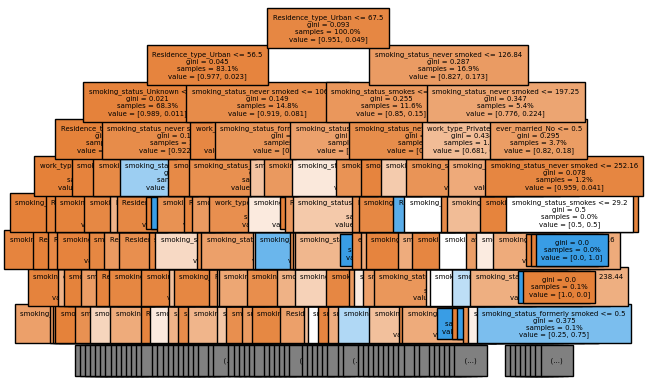

In [293]:
# Create pipeline for pruning
pipe_prune = make_pipeline(preprocess,
                            GridSearchCV(clf,
                            param_grid = [{'max_depth': list(range(0, 110, 10))}],
                            return_train_score=True,
                            scoring=scorer)) #scoring='recall'

pipe_prune.fit(X_dev, y_dev)
grid_search_results_prune = pipe_prune.named_steps['gridsearchcv']
print(f"Best train score: ", grid_search_results_prune.best_score_)
print(f"Best train alpha: ", grid_search_results_prune.best_params_)
print(f"Test score:", pipe_prune.score(X_test, y_test))
best_tree_prune = grid_search_results_prune.best_estimator_
tree_dot = plot_tree(best_tree_prune, feature_names=feature_names, fontsize=5, filled=True, max_depth=8, proportion=True)
plt.show()

**Your Comments Here**

I choose to use 'max_depth' since a deeper tree would memorize the data, including the majority class, leading to overfitting.

**1.10: List the top 3 most important features for this trained tree? How would you justify these features being the most important?**

Text(0.5, 1.0, 'Feature Importance cross Features')

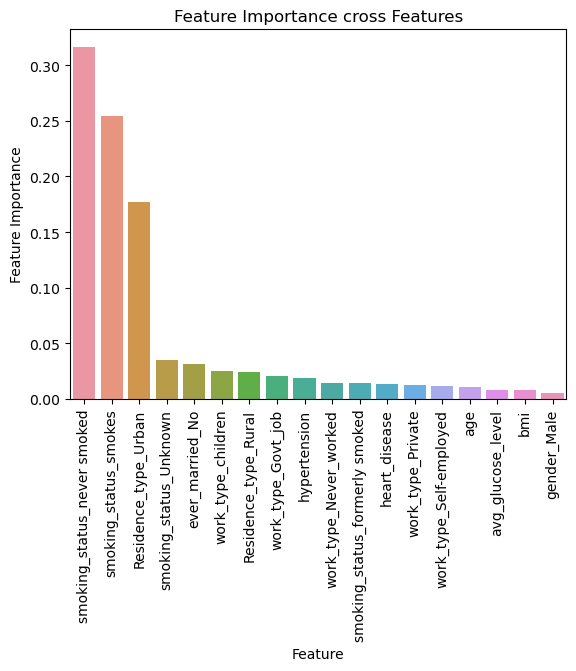

In [294]:
fig, ax = plt.subplots()
ohe_feature_names = preprocess.named_transformers_["onehotencoder"].get_feature_names_out().tolist()
feature_names = num_features + ohe_feature_names
feat_imps = zip(feature_names, best_tree_prune.feature_importances_)
feats, imps = zip(*(sorted(list(filter(lambda x: x[1] != 0, feat_imps)), key=lambda x: x[1], reverse=True)))
ax = sns.barplot(x=list(feats), y=list(imps))
ax.tick_params(axis='x', rotation=90)
ax.set_ylabel('Feature Importance')
ax.set_xlabel('Feature')
ax.set_title('Feature Importance cross Features')

**Your Comments Here**

'smoking_status_never', 'smoking_status_smokes', 'Residence_type_Urban' are top3 most important features, as it has been shown in the feature importance plot. Also, those three features are on the top of the tree plot, which indicates the highest gini splits

## Question 2: Random Forests

**2.1: Train a Random Forest model on the development dataset using RandomForestClassifier class in sklearn. Use the default parameters. Evaluate the performance of the model on test dataset. Does this perform better than Decision Tree on the test dataset (compare to results in Q 1.6)?**

In [295]:
rf = RandomForestClassifier(random_state=1)
preprocess = make_column_transformer(
                                    (OneHotEncoder(handle_unknown='ignore'),ohe_features),
                                    remainder="passthrough")
rf_pipe = make_pipeline(preprocess,
                    GridSearchCV(rf,
                                param_grid = [{}],
                                return_train_score=True,
                                scoring=scorer))
  
rf_pipe.fit(X_dev, y_dev)
grid_search_results_rf = rf_pipe.named_steps['gridsearchcv']
print(f"Best train score: ", grid_search_results_rf.best_score_)
print(f"Best train alpha: ", grid_search_results_rf.best_params_)
print(f"Test score:", rf_pipe.score(X_test, y_test))

Best train score:  0.5037138258346484
Best train alpha:  {}
Test score: 0.49897119341563784


**Your Comments Here**


No, Random Forest do not perform as good as Decision Tree. Both training score and testing score decrease. 

**2.2: Does all trees in the trained random forest model have pure leaves? How would you verify this?**

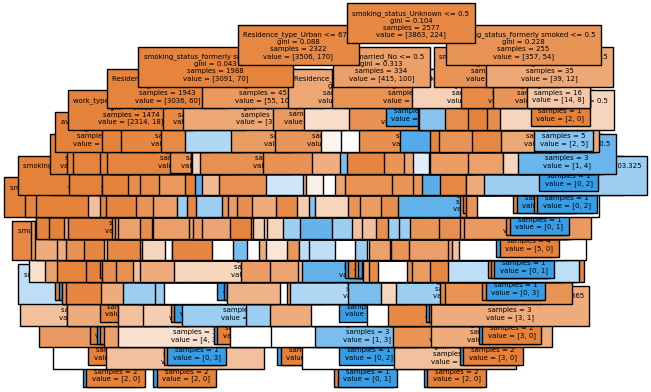

In [297]:
tree_dot = plot_tree(grid_search_results_rf.best_estimator_.estimators_[0],
                    feature_names=feature_names,
                    filled=True,
                    fontsize=5)
plt.show()

**Your Comments Here**

Yes, all trees in random forest have pure leaves, as I set max_depth = None, which is the default setting. Moreover, the default setting of min_sample_split is 2. It means that the minimum of sample to be splitted is 2, so the model will keep splitting the nodes until it is pure. 

**2.3: Assume you want to improve the performance of this model. Also, assume that you had to pick two hyperparameters that you could tune to improve its performance. Which hyperparameters would you choose and why?**


In [304]:
n_estimators = [5, 10, 15, 20, 30]
max_features = ['auto', 'sqrt', 'log2', 0.5, 2]

**Your Comments Here**

I'll choose to tune 'n_estimators' and 'max_features' hyperparameters, as these values should vary based on data size and data's features, so they make great candidates to have impact on overall performance.

**2.4: Now, assume you had to choose up to 5 different values (each) for these two hyperparameters. How would you choose these values that could potentially give you a performance lift?**

**Your Comments Here**

I will choose the values that are evenly larger and smaller than the default setting. If further optimization is required, I'll set up more values for each hyperparameter. 
The default setting of 'n_estimators' is 10, so I will choose [5, 10, 15, 20, ...]. On the other hand, the default value of max_features is auto. I will add more options to increase the diversity among the trees in random forest while considering for each split. 

**2.5: Perform model selection using the chosen values for the hyperparameters. Use cross-validation for finding the optimal hyperparameters. Report on the optimal hyperparameters. Estimate the performance of the optimal model (model trained with optimal hyperparameters) on test dataset? Has the performance improved over your plain-vanilla random forest model trained in Q2.1?**

In [305]:
rf_pipe_tune = make_pipeline(preprocess,
                    GridSearchCV(rf,
                                param_grid = [{
                                    'n_estimators': n_estimators,
                                    'max_features': max_features
                                }],
                                return_train_score=True,
                                scoring=scorer))

rf_pipe_tune.fit(X_dev, y_dev)
grid_search_results_rf_tune = rf_pipe_tune.named_steps['gridsearchcv']
print(f"Best train score: ", grid_search_results_rf_tune.best_score_)
print(f"Best train alpha: ", grid_search_results_rf_tune.best_params_)
print(f"Test score:", rf_pipe_tune.score(X_test, y_test))

Best train score:  0.5234974438123539
Best train alpha:  {'max_features': 0.5, 'n_estimators': 5}
Test score: 0.5243415637860083


**Your Comments Here**

The optimal hyperparameters is 'max_features' = 0.5 and 'n_estimators' = 5

The performance increase by about 2% in performance of both training and testing process. 

**2.6: Can you find the top 3 most important features from the model trained in Q2.5? How do these features compare to the important features that you found from Q1.9? If they differ, which feature set makes more sense?**

Text(0.5, 1.0, 'Feature Importance cross Features')

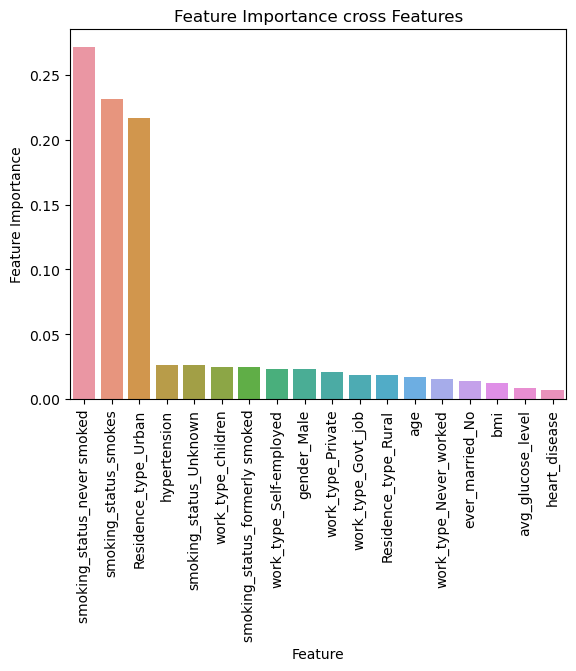

In [306]:
best_rf_tune = grid_search_results_rf_tune.best_estimator_
feat_imps = zip(feature_names, best_rf_tune.feature_importances_)
feats, imps = zip(*(sorted(list(filter(lambda x: x[1] != 0, feat_imps)), key=lambda x: x[1], reverse=True)))
ax = sns.barplot(x=list(feats), y=list(imps))
ax.tick_params(axis='x', rotation=90)
ax.set_ylabel('Feature Importance')
ax.set_xlabel('Feature')
ax.set_title('Feature Importance cross Features')

**Your Comments Here**

The top3 most important features from the random forest model is the same as those from the decision tree model. 

## Question 3: Gradient Boosted Trees

**3.1: Choose three hyperparameters to tune GradientBoostingClassifier and HistGradientBoostingClassifier on the development dataset using 5-fold cross validation.  
You can use GridSearchCV, however make sure to use appropriate metric for the scoring parameter of GridSearchCV.  
Report on the time taken to do model selection for both the models. Also, report the performance of the test
dataset from the optimal models.**

In [308]:
from sklearn.ensemble import GradientBoostingClassifier
learning_rate = [.01, .1, .2]
n_estimators = [50, 100, 200]
max_depth = [2,3,6]
gb = GradientBoostingClassifier(random_state=81)
preprocess = make_column_transformer(
                                    (OneHotEncoder(handle_unknown='ignore'),ohe_features),
                                     remainder="passthrough"
                                    )
pipe_gb = make_pipeline(preprocess,
                        GridSearchCV(gb,
                                param_grid = [{'learning_rate': learning_rate, 
                                              'n_estimators': n_estimators,
                                              'max_depth': max_depth}],
                                return_train_score=True,
                                scoring=scorer,
                                cv=5))
  
pipe_gb.fit(X_dev, y_dev)
grid_search_results_gb = pipe_gb.named_steps['gridsearchcv']
print(f"Best train score: ", grid_search_results_gb.best_score_)
print(f"Best train alpha: ", grid_search_results_gb.best_params_)
print(f"Test score:", pipe_gb.score(X_test, y_test))

Best train score:  0.52876160228988
Best train alpha:  {'learning_rate': 0.2, 'max_depth': 6, 'n_estimators': 50}
Test score: 0.502798353909465


In [309]:
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.base import TransformerMixin

class DenseTransformer(TransformerMixin):
    def fit(self, X,y=None,**fit_params):
        return self
    
    def transform(self, X, y=None, **fit_params):
        
        return X.todense()

learning_rate = [.01, .1, .2]
n_estimators = [50, 100, 200]
max_depth = [2, 3, 6]

hgb = HistGradientBoostingClassifier(random_state=1)
preprocess = make_column_transformer(
                                    (OneHotEncoder(handle_unknown='ignore', sparse=False),ohe_features),
                                     remainder="passthrough"
                                    )
pipe_hgb = make_pipeline(preprocess,
                    #DenseTransformer(),
                    GridSearchCV(hgb,
                                param_grid = [{'learning_rate': learning_rate, 
                                              'max_iter': n_estimators,
                                              'max_depth': max_depth}],
                                return_train_score=True,
                                scoring=scorer,
                                cv=5))
  
pipe_hgb.fit(X_dev, y_dev)
grid_search_results_hgb = pipe_hgb.named_steps['gridsearchcv']
print(f"Best train score: ", grid_search_results_hgb.best_score_)
print(f"Best train alpha: ", grid_search_results_hgb.best_params_)
print(f"Test score:", pipe_hgb.score(X_test, y_test))

Best train score:  0.5476677358168361
Best train alpha:  {'learning_rate': 0.2, 'max_depth': 6, 'max_iter': 100}
Test score: 0.5463991769547325


**Your Comments Here** :

GradientBoosting: 51.3s

Hist: 1m 9.4s

The macro recall score on testing data in Gradient Boosting Classifer is 0.502798353909465, and HistGradientBoostingClassifier is 0.5463991769547325. 



**3.2: Train an XGBoost model by tuning 3 hyperparameters using 10 fold cross-validation. Compare the performance of the trained XGBoost model on the test dataset against the performances obtained from 3.1**

In [311]:
from xgboost import XGBClassifier
eta = [.01, .1, .2]
max_depth = [3, 6, 9]
n_estimators = [50, 100, 150]

xgbc = XGBClassifier(random_state=81)
preprocess = make_column_transformer(
                                    (OneHotEncoder(handle_unknown='ignore'),ohe_features),
                                     remainder="passthrough"
                                    )
pipe_xgb = make_pipeline(preprocess,
                    GridSearchCV(xgbc,
                                param_grid = [{'eta': eta, 
                                              'max_depth': max_depth,
                                              'n_estimators': n_estimators}],
                                return_train_score=True,
                                scoring = scorer,
                                cv=10))
  
pipe_xgb.fit(X_dev, y_dev)
grid_search_results_xgb = pipe_xgb.named_steps['gridsearchcv']
print(f"Best train score: ", grid_search_results_xgb.best_score_)
print(f"Best train alpha: ", grid_search_results_xgb.best_params_)
print(f"Test score:", pipe_xgb.score(X_test, y_test))

Best train score:  0.5217126255532293
Best train alpha:  {'eta': 0.2, 'max_depth': 6, 'n_estimators': 150}
Test score: 0.5163991769547325


**Your Comments Here** :

GradientBoostingClassifer: 0.502798353909465

HistGradientBoostingClassifier: 0.546399176954732

XGBClassifier: 0.5163991769547325

The HistGradientBoostingClassifier has the highest macro recall score.


**3.3: Can you list the top 3 features from the trained XGBoost model? How do they differ from the features found from Random Forest and Decision Tree? Which one would you trust the most?**

Text(0.5, 1.0, 'Feature Importance cross Features')

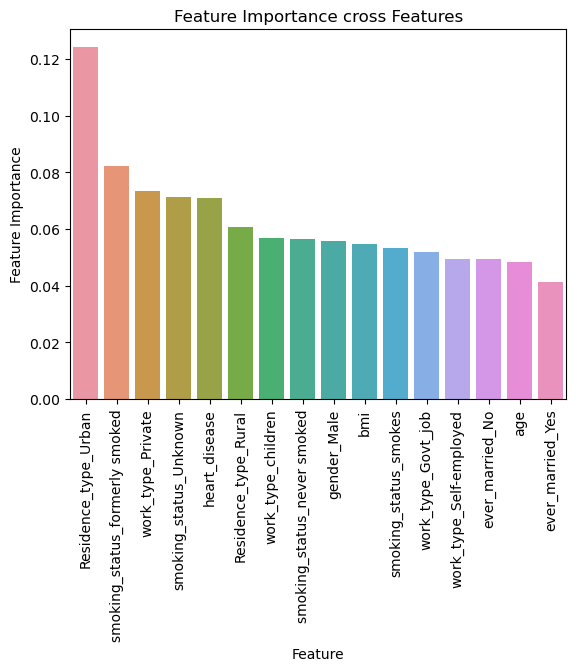

In [312]:
# plot the feature importance bar chart
best_xgb = grid_search_results_xgb.best_estimator_
xgb_feat_imps = zip(feature_names, best_xgb.feature_importances_)
xgb_feats, xgb_imps = zip(*(sorted(list(filter(lambda x: x[1] != 0, xgb_feat_imps)), key=lambda x: x[1], reverse=True)))
ax = sns.barplot(x=list(xgb_feats), y=list(xgb_imps))
ax.tick_params(axis='x', rotation=90)
ax.set_ylabel('Feature Importance')
ax.set_xlabel('Feature')
ax.set_title('Feature Importance cross Features')

**Your Comments Here**

'smoking_status_never', 'smoking_status_smokes', 'Residence_type_Urban' are the top 3 most important features from the trained Decision Tree and Random Forest model. 

'Residence_type_Urban', 'smoking_status_formerly smoked', 'work_type_Private' are the top 3 most important features from the trained XGBoost model. 

I'll trust XGBoost model more, as this aligns more closely with my intuition that living in an urban environment could have a more comprehensive impact on health—both physical and mental. On the other hand, the Decision Tree and Random Forest models focus on the smoking status as the key factors.  

**3.4: Can you choose the top 7 features (as given by feature importances from XGBoost) and repeat Q3.2? Does this model perform better than the one trained in Q3.2? Why or why not is the performance better?**

In [314]:
from sklearn.feature_selection import SelectFromModel

# Use SelectFromModel and set threshold to only keep top 7 features
feature_selector = SelectFromModel(best_xgb, max_features=7, prefit=True)

eta = [.01, .1, .2]
max_depth = [3, 6, 9]
n_estimators = [50, 100, 150]

xgbc = XGBClassifier(random_state=1)
preprocess = make_column_transformer(
                                    (OneHotEncoder(handle_unknown='ignore'),ohe_features),
                                     remainder="passthrough"
                                    )
pipe_xgb = make_pipeline(preprocess,
                        feature_selector,
                        GridSearchCV(xgbc,
                                param_grid = [{'eta': eta, 
                                              'max_depth': max_depth,
                                              'n_estimators': n_estimators}],
                                              
                                return_train_score=True,
                                cv=10,
                                scoring=scorer))
  
pipe_xgb.fit(X_dev, y_dev)
grid_search_results_xgb = pipe_xgb.named_steps['gridsearchcv']
print(f"Best train score: ", grid_search_results_xgb.best_score_)
print(f"Best train alpha: ", grid_search_results_xgb.best_params_)
print(f"Test score:", pipe_xgb.score(X_test, y_test))

Best train score:  0.519086803816846
Best train alpha:  {'eta': 0.2, 'max_depth': 9, 'n_estimators': 150}
Test score: 0.5238271604938272


**Your comments here**

The test score in Q3.2 model is 0.5163991769547325, and the score here is 0.5238271604938272. 

The performance is better since the reduced feature set minimized the risk of overfitting, thereby enhancing the generalization ability on new data.

**3.5: Compare the results on the test dataset from XGBoost, HistGradientBoostingClassifier, GradientBoostingClassifier with results from Q1.6 and Q2.1. Which model tends to perform the best and which one does the worst? How big is the difference between the two? Which model would you choose among these 5 models and why?**

## Question 4: Calibration

**4.1: Estimate the brier score for the XGBoost model (trained with optimal hyperparameters from Q3.2) scored on the test dataset.**

In [318]:
## YOUR CODE HERE
from sklearn.metrics import brier_score_loss
y_prob = pipe_xgb.predict_proba(X_test)[:, 1]
brier_score = brier_score_loss(y_test, y_prob)
print(f"Brier Score: {brier_score}")

Brier Score: 0.04697559656379248


**4.2: Calibrate the trained XGBoost model using isotonic regression as well as Platt scaling. Plot predicted v.s. actual on test datasets from both the calibration methods. Report brier score after calibration.**

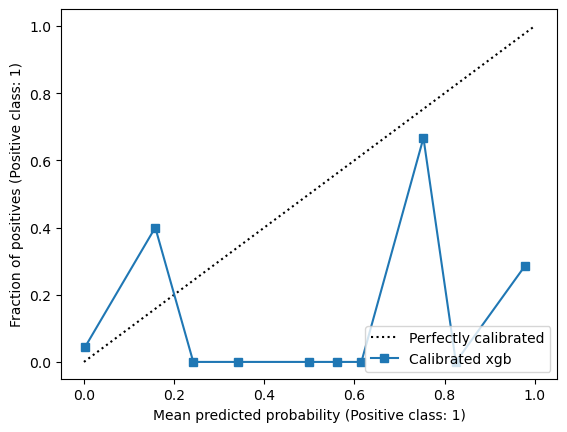

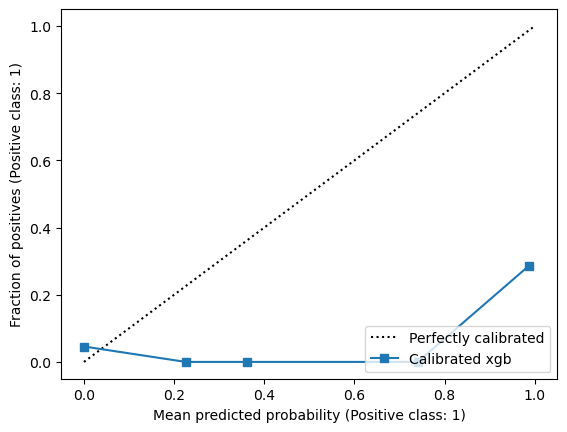

In [325]:
from sklearn.calibration import calibration_curve, CalibrationDisplay
from sklearn.calibration import CalibratedClassifierCV
X_train, X_Calib, y_train, y_Calib = train_test_split(X_dev, y_dev, test_size=0.2, random_state=1)
cal_platt = CalibratedClassifierCV(pipe_xgb, cv='prefit', method='sigmoid')
cal_platt.fit(X_Calib, y_Calib)
display = CalibrationDisplay.from_estimator(cal_platt, X_test, y_test, n_bins=10, name="Calibrated xgb")

cal_iso = CalibratedClassifierCV(pipe_xgb, cv='prefit', method='isotonic')
cal_iso.fit(X_Calib, y_Calib)
display = CalibrationDisplay.from_estimator(cal_iso, X_test, y_test, n_bins=10, name="Calibrated xgb")

**4.3: Report brier scores from both the calibration methods. Do the calibration methods help in having better predicted probabilities?**

In [326]:
## YOUR CODE HERE
y_prob1 = cal_platt.predict_proba(X_test)[:, 1]
brier_score_platt = brier_score_loss(y_test, y_prob1)
y_prob2 = cal_iso.predict_proba(X_test)[:, 1]
brier_score_iso = brier_score_loss(y_test, y_prob2)
print(f"Brier Score of platt: {brier_score_platt}\nBrier Score of isotonic: {brier_score_iso}")


Brier Score of platt: 0.052304682391853034
Brier Score of isotonic: 0.055830673295056574


No it doesn't help in having better predicted probabilities